<a href="https://colab.research.google.com/github/milansua/Projectschool/blob/main/Train_a_Food_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training a Food Classifier


## Load and prepare Data

First we need to update the notebook to the latest version of fastai.

In [ ]:
!pip install -Uqq fastai
from fastai.vision.all import *

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 33.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 22.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 31.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 54.8 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


At first we are downloading the Food Dataset, containing about 100k images of various kind of foods.
Documentation for all Datasets: https://docs.fast.ai/data.external

In [3]:
foodPath= ('/content/drive/MyDrive/Projectschool/state_dataset/train')

In [4]:
from fastai.vision.all import *
from fastai.data.transforms import get_image_files # Explicitly import get_image_files.

#How many images are we dealing with
len(get_image_files(foodPath))

8586

<Axes: >

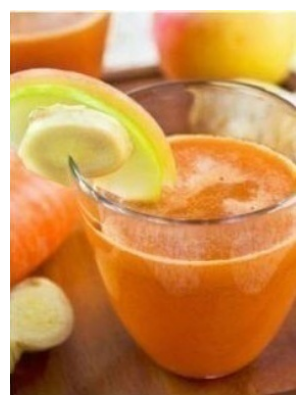

In [5]:
imag=PILImage.create(get_image_files(foodPath)[10])
imag.show()

In [8]:
#Use Pandas to parse the JSON as a human readable table
pd.read_json('/content/drive/MyDrive/Projectschool/state_dataset/train/image_data.json')

,folder,image
0,juiced,juiced/0267.jpg
1,juiced,juiced/0298.jpg
2,juiced,juiced/orange_juiced_85.jpg
3,juiced,juiced/0515.jpg
4,juiced,juiced/milk_juiced_160.jpg
...,...,...
8581,whole,whole/0444.jpg
8582,whole,whole/0524.jpg
8583,whole,whole/0083.jpg
8584,whole,whole/44.web_Black-Garlic-Whole-2.jpg


In [7]:
import os
import json
from google.colab import drive



# STEP 2: Set your dataset directory inside Google Drive
dataset_dir = "/content/drive/MyDrive/Projectschool/state_dataset/train"  # <-- UPDATE THIS PATH

# STEP 3: Check if the path exists
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f"❌ The dataset path does not exist: {dataset_dir}")

# STEP 4: Create a list to store image paths and labels
data = []

# Loop through each folder (category) inside the dataset directory
for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)

    # Check if it's a directory
    if os.path.isdir(folder_path):
        # List all image files in the folder
        images = [img for img in os.listdir(folder_path) if img.endswith(('.jpg', '.jpeg', '.png'))]

        # Add each image with its corresponding folder (label)
        for img in images:
            data.append({"folder": folder, "image": os.path.join(folder, img)})

# STEP 5: Save the JSON file inside Google Drive
json_path = os.path.join(dataset_dir, "image_data.json")
with open(json_path, "w") as json_file:
    json.dump(data, json_file, indent=4)

print(f"✅ JSON file created: {json_path}")

# STEP 6: Download the JSON file to your local computer
from google.colab import files
files.download(json_path)


✅ JSON file created: /content/drive/MyDrive/Projectschool/state_dataset/train/image_data.json


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [9]:
#Deciding which two foods we want to classify
labelA = 'juiced'
labelB = 'diced'
labelC = 'floured'
labelD = 'creamy_paste'
labelE = 'jullienne'
labelF = 'other'
labelG = 'peeled'
labelH = 'whole'
labelI = 'mixed'


**Some Data Preperation**

Next we're gonna do some preperation to make the data handling easier. It's not important that you understand the following code snippet completly.

We're just doing two things:


1.   Removing all images that don't have labelA or labelB
2.   Renaming images with labelA or labelB to have that label in their filename



In [13]:
import os
from fastai.vision.all import get_image_files

# Define the actual labels (corresponding to the image)
labels = {
    "A": "juiced",
    "B": "diced",
    "C": "floured",
    "D": "creamy_paste",
    "E": "jullienne",
    "F": "other",
    "G": "peeled",
    "H": "whole",
    "I": "mixed"
}

# Loop through all images in the dataset
for img in get_image_files(foodPath):
    img_name = str(img.name)  # Convert image path to string

    # Check if the image belongs to one of the labels
    found_label = None
    for short_label, full_label in labels.items():
        if short_label in img_name:
            found_label = full_label
            break  # Stop once we find the first matching label

    if found_label:
        # Rename image to include the full label at the beginning
        new_name = f"{found_label}-{img.name}"
        img.rename(img.parent / new_name)  # Rename image file
    else:
        # If the image does not belong to any valid label, delete it
        os.remove(img)

# Check the number of images left after filtering
print(f"✅ Remaining images: {len(get_image_files(foodPath))}")



✅ Remaining images: 448


## Train Model

In [11]:
def GetLabel(fileName):
  return fileName.split('-')[0]

GetLabel("churros-734186.jpg") #Testing

'churros'

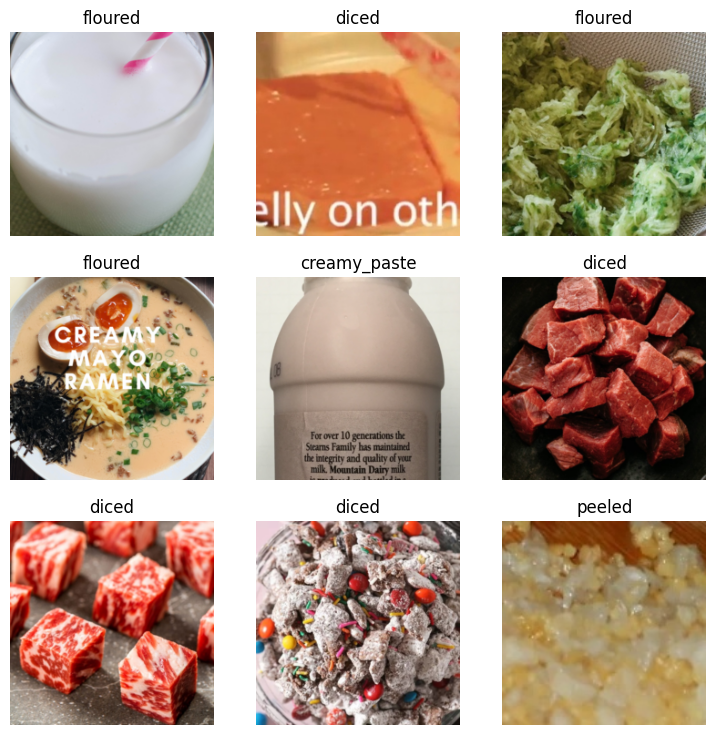

In [15]:
dls = ImageDataLoaders.from_name_func(
    foodPath, get_image_files(foodPath), valid_pct=0.2, seed=100,
    label_func=GetLabel, item_tfms=Resize(224))

dls.train.show_batch()

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate, pretrained=True)
learn.fine_tune(epochs=1)

Check out this while training to have look inside a Convolutional Neural Network.

https://distill.pub/2017/feature-visualization/

## Verify Model

### Upload your own Images

In [ ]:
from google.colab import files
uploader = files.upload()

for img in uploader.items():
  uploadedImg = img[0]

img = PILImage.create(uploadedImg)
img.show()

label,_,probs = learn.predict(img)

print(f"This is a {label}.")
print(f"{labelA} {probs[1].item():.6f}")
print(f"{labelB} {probs[0].item():.6f}")

### Test using images in dataset

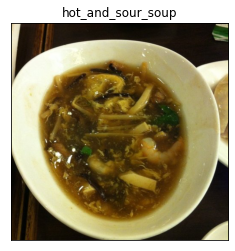

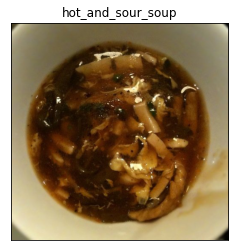

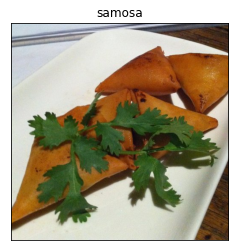

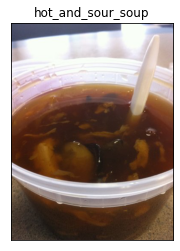

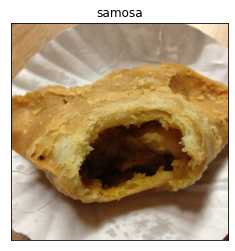

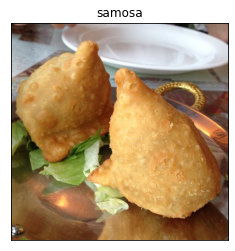

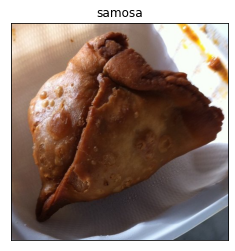

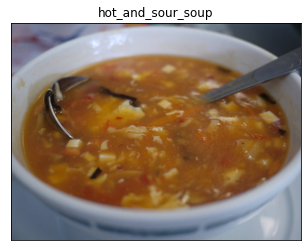

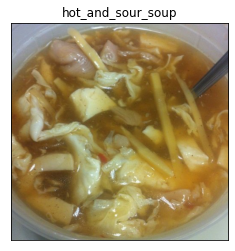

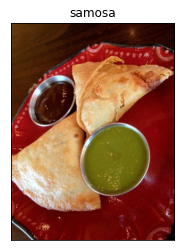

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

for i in range(0,10):
  #Load random image
  randomIndex = random.randint(0, len(get_image_files(foodPath))-1)
  img = mpimg.imread(get_image_files(foodPath)[randomIndex])
  #Put into Model
  label,_,probs = learn.predict(img)

  #Create Figure using Matplotlib
  fig = plt.figure()
  ax = fig.add_subplot() #Add Subplot (For multiple images)
  imgplot = plt.imshow(img) #Add Image into Plot
  ax.set_title(label) #Set Headline to predicted label

  #Hide numbers on axes
  plt.gca().axes.get_yaxis().set_visible(False)
  plt.gca().axes.get_xaxis().set_visible(False)

### Confusion Matrix (optional)

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
interp.plot_top_losses(6)

## Deploy

In [ ]:
learn.export() #exports model as 'export.pkl' by default

In [ ]:
#let's grab the first pkl file we can find
modelPath = get_files(foodPath, '.pkl')[0]
modelPath

Path('/root/.fastai/data/food-101/export.pkl')

In [ ]:
learn_inf = load_learner(modelPath)
learn_inf.predict(mpimg.imread(get_image_files(foodPath)[0])) #raw prediction

('hot_and_sour_soup', tensor(0), tensor([1.0000e+00, 4.4640e-08]))

In [ ]:
learn_inf.dls.vocab #Get the labels

['hot_and_sour_soup', 'samosa']

In [ ]:
#This seems to only work properly in Chrome
from google.colab import files
files.download(modelPath)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Alternative download method
Download for non-chrome users only:

In [ ]:
shutil.move(str(modelPath), './')

This has moved the file. You should now be able to see it in the Colab File browser on the right and download it there.

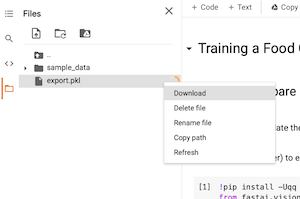